# Miscellaneous figures and remarks for Clonesig
The objective of this notebook is to summarize some minor figures (mostly supplementary data) for Clonesig.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from clonesig.data_loader import MAFLoader, SimLoader, beta_binomial
from clonesig.estimator import _get_projected
from clonesig.estimator import *
import time
from sklearn.cluster import KMeans
from sklearn import linear_model
from pathlib import Path

running on server, otherwise please investigate
running on server, otherwise please investigate


In [2]:
os.chdir('..')
output_path = '20200515_paper_figures/Miscellaneous'
Path(output_path).mkdir(parents=True, exist_ok=True)

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Illustration of failure of the BIC criterion for small number of mutations

In [4]:
sig_file_path = "external_data/signatures_probabilities.txt"
SIG = pd.read_csv(sig_file_path, sep='\t', index_col=0)
sig_cols = ['Signature {}'.format(i) for i in range(1, 31)]
SIG = SIG.assign(sortkey=SIG.index + SIG.Trinucleotide)
SIG = SIG.sort_values(by='sortkey')
SIG_MATRIX = SIG[sig_cols].as_matrix().T
M, K = SIG_MATRIX.shape
NEW_SIG_MATRIX = SIG_MATRIX + 0.00001 * (SIG_MATRIX == 0)
MU = NEW_SIG_MATRIX / NEW_SIG_MATRIX.sum(axis=1)[:, np.newaxis]

/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [5]:
def fit_model_special(T, B, C_normal, C_tumor_tot, C_tumor_minor, D, purity,
                      inputMU, nb_fits=1, seeds=None, max_nb_clones=6, extra=4,
                      inputNU=None):
    """
    possible metrics : F, loglikelihood, BIC, AIC, AICc, ICL_q, ICL_qn, SH.
    """
    L = inputMU.shape[0]
    if isinstance(seeds, Iterable):
        if len(seeds) != nb_fits:
            raise ValueError("Number of seeds is incompatible with number of required fits")
    if seeds is None:
        seeds = list(range(nb_fits))
    bic = np.zeros((nb_fits, max_nb_clones+extra))
    loglikelihood = np.zeros((nb_fits, max_nb_clones+extra))
    aic = np.zeros((nb_fits, max_nb_clones+extra))
    aicc = np.zeros((nb_fits, max_nb_clones+extra))
    icl_q = np.zeros((nb_fits, max_nb_clones+extra))
    icl_qn = np.zeros((nb_fits, max_nb_clones+extra))
    for i, s in enumerate(seeds):
        np.random.seed(s)
        for j, nb_clones in enumerate(range(1, max_nb_clones+1+extra)):
            print(j, i)
            if nb_clones >= 2:
                to_split = np.argmax(-(est.qun * np.log(est.qun)).sum(axis=0))
                mask = np.ones(nb_clones-1, dtype=bool)
                mask[to_split] = 0
                new_phi = np.zeros(nb_clones)
                new_phi[:nb_clones - 2] = est.phi[mask]
                new_phi[-2] = np.random.ranf() * 0.8 + 0.1
                new_phi[-1] = np.random.ranf() * 0.8 + 0.1
                new_xi = np.zeros(nb_clones)
                new_xi[:nb_clones - 2] = est.xi[mask]
                new_xi[-1], new_xi[-2] = [est.xi[to_split]] * 2
                new_pi = np.zeros((nb_clones, inputMU.shape[0]))
                new_pi[:nb_clones - 2, :] = est.pi[mask, :]
                new_pi[-1, :] = np.random.dirichlet(alpha=np.ones(inputMU.shape[0]))
                new_pi[-2, :] = np.random.dirichlet(alpha=np.ones(inputMU.shape[0]))
                est = Estimator(T, B, C_normal, C_tumor_tot,
                                C_tumor_minor, D, purity, nb_clones,
                                inputMU=inputMU, pi=new_pi, phi=new_phi, xi=new_xi, nu=inputNU)
            else:
                est = Estimator(T, B, C_normal, C_tumor_tot,
                                C_tumor_minor, D, purity, nb_clones,
                                inputMU=inputMU, nu=inputNU)
            est.fit()
            print(nb_clones, est.tau)
            bic[i, j] = est.get_bic()
            loglikelihood[i, j] = est.get_loglikelihood
            aic[i, j] = est.get_aic()
            aicc[i, j] = est.get_aicc()
            icl_q[i, j] = est.get_icl()
            icl_qn[i, j] = est.get_icl(norm=True)
    dict_results = {'bic': np.argmax(bic.mean(axis=0)) + 1,
                    'aic': np.argmax(aic.mean(axis=0)) + 1,
                    'aicc': np.argmax(aicc.mean(axis=0)) + 1,
                    'icl_q': np.argmax(icl_q.mean(axis=0)) + 1,
                    'icl_qn': np.argmax(icl_qn.mean(axis=0)) + 1}

    # compute SH estimate
    for mc in range(max_nb_clones-2, max_nb_clones + extra + 1):
        slopes = list()
        chpt = list()
        for end_p in range(0, mc-1):
            ransac = linear_model.LinearRegression()
            ransac.fit(((np.array(range(end_p+1, mc+1)))*(L+1)).reshape(-1, 1), loglikelihood.mean(axis=0)[end_p:mc])
            slopes.append(ransac.coef_)
            # print('pen', mc, end_p, loglikelihood[0][:mc] - np.arange(1, len(loglikelihood[0][:mc])+1) * (M+1) * 2 * ransac.estimator_.coef_)
            chpt.append(np.argmax(loglikelihood.mean(axis=0)[:mc] - np.arange(1, len(loglikelihood.mean(axis=0)[:mc])+1) * (L+1) * 2 * max(ransac.coef_, 0.0))+1)
        chpt = np.array(chpt)
        diff = chpt[1:] - chpt[0:-1]
        last_point = np.argmax(diff<0)
        if (last_point == 0) & (chpt[1] >= chpt[0]):
            last_point = mc
        counts = np.bincount(chpt[:last_point+1])
        # b = counts[::-1]
        # final_nb_clones = len(b) - np.argmax(b) - 1
        final_nb_clones = np.argmax(counts)
        dict_results['sh_{}'.format(mc)] = final_nb_clones

    ll = loglikelihood.mean(axis=0)
    dict_results['max_curvature'] = np.argmax(
        np.abs(ll[2:] + ll[0: -2] - 2 * ll[1: -1])) + 2
    return dict_results, ll, bic

0 0
1 0.15104139842308853
1 0
2 0.044908602630422755
2 0
3 0.009372606569964114
3 0
4 0.008034061649308774
4 0
5 0.0074528442894857706
5 0
6 0.007455097454504605
6 0
7 0.007908457116802001
7 0
8 0.007847047039254916
8 0
9 0.007246112530144139
9 0
10 0.007254240845879775


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


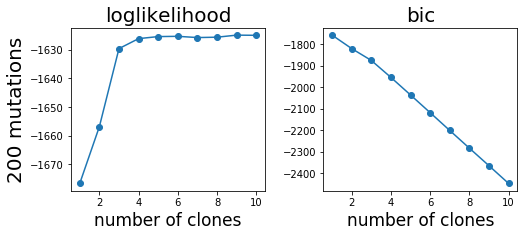

In [6]:
N = 200
J = 3
np.random.seed(2)
#phi = np.linspace(0.1, 0.99, J)
#pi = np.zeros((J, M))
#for i, sig in enumerate(np.random.choice(30, J, replace=False)):
#    pi[i, sig] = 1
#xi = np.ones(J)/J
uu = SimLoader(N, J, rho_param=100, cn=False, inputMU=MU)
uu._get_unobserved_nodes()
uu._get_observed_nodes()
dict_results, ll, bic = fit_model_special(uu.T, uu.B, uu.C_normal, uu.C_tumor_tot,
                                     uu.C_tumor_minor, uu.D, uu.purity,
                                     MU, nb_fits=1, extra=4)
titles = ('loglikelihood', 'bic')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for i, v in enumerate((ll, bic[0])):
    ax[i].plot(range(1, 11), v, marker='o')
    ax[i].set_title(titles[i], fontsize=20)
    ax[i].set_xlabel("number of clones", fontsize=17)
plt.subplots_adjust(wspace=0.3)
ax[0].set_ylabel("200 mutations", fontsize=20)

plt.savefig('{}/criterion200mut.pdf'.format(output_path), bbox_inches='tight')

0 0
1 0.1506925652991451
1 0
2 0.050023326889151176
2 0
3 0.009950685311592024
3 0
4 0.009856544306647053
4 0
5 0.009099162804855551
5 0
6 0.008810150080905677
6 0
7 0.008865424665644361
7 0
8 0.00879598309335079
8 0
9 0.008594814260544347
9 0
10 0.00866702725156461


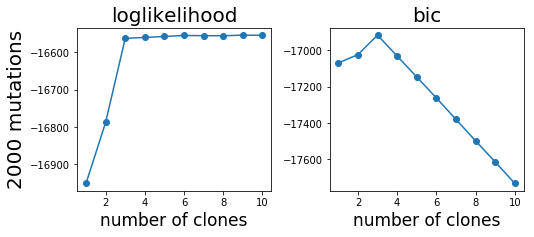

In [7]:
N = 2000
J = 3
np.random.seed(2)
#phi = np.linspace(0.1, 0.99, J)
#pi = np.zeros((J, M))
#for i, sig in enumerate(np.random.choice(30, J, replace=False)):
#    pi[i, sig] = 1
#xi = np.ones(J)/J
uu = SimLoader(N, J, rho_param=100, cn=False, inputMU=MU)
uu._get_unobserved_nodes()
uu._get_observed_nodes()
dict_results, ll, bic = fit_model_special(uu.T, uu.B, uu.C_normal, uu.C_tumor_tot,
                                     uu.C_tumor_minor, uu.D, uu.purity,
                                     MU, nb_fits=1, extra=4)
titles = ('loglikelihood', 'bic')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for i, v in enumerate((ll, bic[0])):
    ax[i].plot(range(1, 11), v, marker='o')
    ax[i].set_title(titles[i], fontsize=20)
    ax[i].set_xlabel("number of clones", fontsize=17)
plt.subplots_adjust(wspace=0.3)
ax[0].set_ylabel("2000 mutations", fontsize=20)

plt.savefig('{}/criterion2000mut.pdf'.format(output_path), bbox_inches='tight')

## Illustration of the distribution of copy number from simulated data

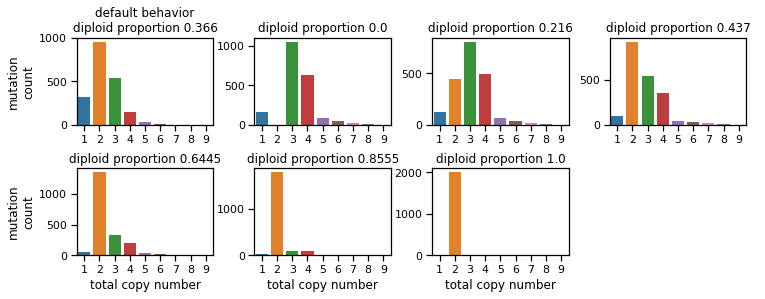

In [8]:
sns.set_context('notebook')
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 4))
for i, perc_dip in enumerate((None, 0, 0.20, 0.40, 0.60, 0.80, 1)):
    N = 2000
    J = 3
    np.random.seed(2)
    uu = SimLoader(N, J, rho_param=100, cn=True, dip_prop=perc_dip)
    uu._get_unobserved_nodes()
    uu._get_observed_nodes()
    true_dip_perc = sum((uu.C_tumor_tot==2)&(uu.C_tumor_minor==1))/N
    sns.countplot(pd.Categorical(uu.C_tumor_tot, ordered=True, categories=list(range(1, 10))), ax=ax[i//4, i%4])
    if (i//4==0)&(i%4==0):
        ax[i//4, i%4].set_title('default behavior\ndiploid proportion {}'.format(true_dip_perc))
    else:
        ax[i//4, i%4].set_title('diploid proportion {}'.format(true_dip_perc))
    if i%4!=0:
        ax[i//4, i%4].set_ylabel('')
    else:
        ax[i//4, i%4].set_ylabel('mutation\ncount')
    if i//4==1:
        ax[i//4, i%4].set_xlabel('total copy number')
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    ax[-1, -1].axis('off')
    
plt.savefig('{}/empirical_copy_number_distribution.pdf'.format(output_path), bbox_inches='tight')
